# K-Means Clustering for Images
> In this post, we will use a K-means algorithm to perform image classification. Clustering isn't limited to the consumer information and population sciences, it can be used for imagery analysis as well. Leveraging Scikit-learn and the MNIST dataset, we will investigate the use of K-means clustering for computer vision.

- toc: true 
- badges: true
- comments: true
- author: Austin Chen
- categories: [machine learning, vision]

## 1% Better Everyday
- [K-Means Clustering for Imagery Analysis
](https://goodboychan.github.io/python/machine_learning/natural_language_processing/vision/2020/10/26/01-K-Means-Clustering-for-Imagery-Analysis.html)
- Debug why the accuray looks abnormal. Suspecting that something I did not add in the `get_label2cluster()`

In [5]:
%matplotlib inline

import sys
import sklearn
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf

## Load Datasets

To be quick, I will load the Fashion MNIST from TensorFlow Keras library, which is often used as the "Hello World" of machine learning programs for computer vision.


In [133]:
#fashion_mnist = tf.keras.datasets.fashion_mnist
#(train_x, train_y), (test_x, test_y) = fashion_mnist.load_data()

mnist = tf.keras.datasets.mnist
(train_x, train_y), (test_x, test_y) = mnist.load_data()

11493376/11490434 [==============================] - 0s 0us/step


In [27]:
CLASSES = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
NCLASSES = len(CLASSES)
class2label = {i:c for i,c in enumerate(CLASSES)}

In [9]:
print(f"Training: {train_x.shape}")
print(f"Test: {test_x.shape}")

Training: (60000, 28, 28)
Test: (10000, 28, 28)


AS you can see, the dataset contains images of 28x28x1. Let's print some out and see what they look like.

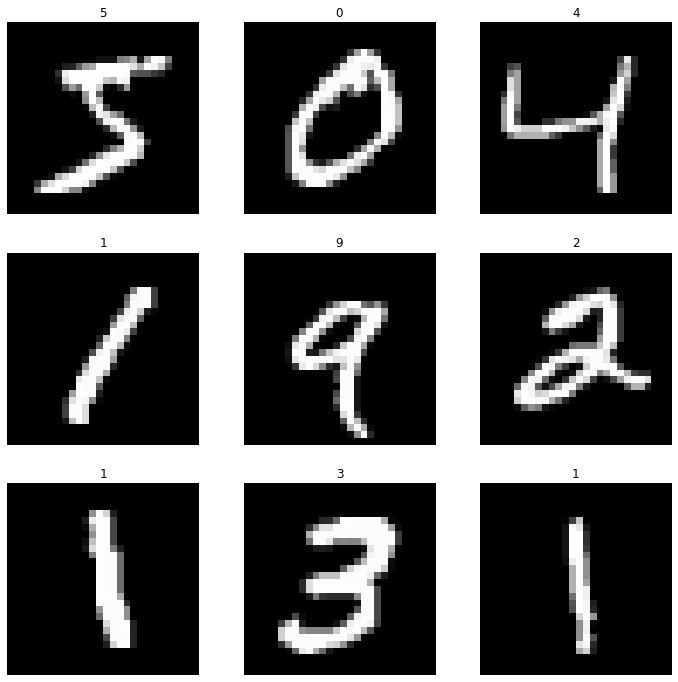

In [134]:
fig,axs = plt.subplots(3,3,figsize=(12,12))
plt.gray()

for i,ax in enumerate(axs.flat):
    ax.imshow(train_x[i])
    ax.axis('off')
    #ax.set_title(f'{class2label[train_y[i]]}')
    ax.set_title(f'{train_y[i]}')

## Preprocessing

### Reshape

Images are formated as 2-dimensional `numpy` arrays. However, the K-means clustering algorithm provided by scikit-learn ingests 1-dimensional arrays; as a result, we will need to reshape each image or precisely wee need to `flatten` the data. 

Clustering algorithms almost always use 1-dimensional data. For example, if you were clustering a set of X, Y coordinates, each point would be passed to the clustering algorithm as a 1-dimensional array with a length of two (example: [2,4] or [-1, 4]). If you were using 3-dimensional data, the array would have a length of 3 (example: [2, 4, 1] or [-1, 4, 5]).

Fashion MNIST contains images that are 28 by 28 pixels; as a result, they will have a length of 784 once we reshape them into a 1-dimensional array.

In [135]:
train_x = train_x.reshape(len(train_x), -1)

In [136]:
print(train_x.shape)

(60000, 784)


In [137]:
train_x = train_x.astype(np.float32) / 255.0

## Applying K-means Clustering
Since the size of the MNIST dataset is quite large, we will use the **mini-batch** implementation of k-means clustering (`MiniBatchKMeans`) provided by scikit-learn. This will dramatically reduce the amount of time it takes to fit the algorithm to the data.

Here, we just choose the `n_clusters` argument to the `n_digits`(the size of unique labels, in our case, 10), and set the default parameters in `MiniBatchKMeans`.

And as you know that, K-means clustering is one of the unsupervised learning. That means it doesn't require any label to train.

In [138]:
from sklearn.cluster import MiniBatchKMeans

In [139]:
kmeans = MiniBatchKMeans(n_clusters=NCLASSES)
kmeans.fit(train_x)

MiniBatchKMeans(batch_size=100, compute_labels=True, init='k-means++',
                init_size=None, max_iter=100, max_no_improvement=10,
                n_clusters=10, n_init=3, random_state=None,
                reassignment_ratio=0.01, tol=0.0, verbose=0)

In [140]:
kmeans.labels_

array([7, 2, 0, ..., 7, 1, 7], dtype=int32)

In [141]:
NCLASSES

10

> Important: These are not real label of each image. These are just group ids that the clustering models label for each input.

To match group ids with actual labels, we can tackle this with following steps:
- Combine each images in the same group
- Check frequency distribution of actual labels (using `np.bincount`)
- Find the most frequent label by `np.argmax` and set the label

In [142]:
def get_label2cluster_mapper(kmeans, ground_trues):

    label2cluster= {}

    for i in range(kmeans.n_clusters):
        indeces = np.where(kmeans.labels_ == i)
        labels = ground_trues[indeces]

        hist = (np.bincount(np.squeeze(labels)))

        if np.argmax(hist) in label2cluster:
            label2cluster[np.argmax(hist)].append(i)
        else:
            label2cluster[np.argmax(hist)] = [i]

    return label2cluster

In [143]:
def convert_cluster_to_label(clusters, mapper):
    preds = np.zeros(len(clusters)).astype(np.uint8)
    for i,cl in enumerate(clusters):
        for k,v in mapper.items():
            if cl in v: preds[i] = k
    return preds

In [144]:
label2cluster = get_label2cluster_mapper(kmeans, train_y)
train_cl = kmeans.predict(train_x)
preds = convert_cluster_to_label(train_cl, label2cluster)
print(preds[:20])
print(train_y[:20])

[8 0 4 1 7 8 1 8 1 7 3 1 3 6 1 7 2 8 6 1]
[5 0 4 1 9 2 1 3 1 4 3 5 3 6 1 7 2 8 6 9]


In [145]:
print(f"Accuracy : {sum(preds == train_y)/len(preds) * 100}%")

Accuracy : 56.015%


As a result, some predicted label is mismatched, but in general k-means clustering does an acceptable jobs of predicting labels.

## Evaluating Clustering 

With the functions defined above, we can now determine the accuracy of our algorithms. Since we are using this clustering algorithm for classification, accuracy is ultimately the most important metric; however, there are other metrics out there that can be applied directly to the clusters themselves, regardless of the associated labels. Two of these metrics that we will use are **inertia** and **homogeneity**. (See the detailed description of [homogeneity_score](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.homogeneity_score.html))

Furthermore, earlier we made the assumption that K = 10 was the appropriate number of clusters; however, this might not be the case. Let's fit the K-means clustering algorithm with several different values of K, than evaluate the performance using our metrics.



In [146]:
from sklearn.metrics import homogeneity_score

def calc_metrics(estimator, data, labels):
    print('Number of Clusters: {}'.format(estimator.n_clusters))
    # Inertia
    inertia = estimator.inertia_
    print("Inertia: {}".format(inertia))
    # Homogeneity Score
    homogeneity = homogeneity_score(labels, estimator.labels_)
    print("Homogeneity score: {}".format(homogeneity))
    return inertia, homogeneity

In [147]:
from sklearn.metrics import accuracy_score

clusters = [10, 16, 36, 64, 144, 256]
iner_list = []
homo_list = []
acc_list = []

for n_clusters in clusters:
    estimator = MiniBatchKMeans(n_clusters=n_clusters)
    estimator.fit(train_x)
    
    inertia, homo = calc_metrics(estimator, train_x, train_y)
    iner_list.append(inertia)
    homo_list.append(homo)
    
    # Determine predicted labels
    labels2cluster = get_label2cluster_mapper(estimator, train_y)
    preds = convert_cluster_to_label(estimator.labels_, label2cluster)
    
    acc = accuracy_score(train_y, preds)
    acc_list.append(acc)
    print('Accuracy: {}\n'.format(acc))

Number of Clusters: 10
Inertia: 2374295.5
Homogeneity score: 0.47531735445630136
Accuracy: 0.058133333333333335

Number of Clusters: 16
Inertia: 2233699.5
Homogeneity score: 0.5342048472152641
Accuracy: 0.13905

Number of Clusters: 36
Inertia: 1958344.25
Homogeneity score: 0.6801597667242121
Accuracy: 0.1241

Number of Clusters: 64
Inertia: 1816912.875
Homogeneity score: 0.7365330512499944
Accuracy: 0.10248333333333333

Number of Clusters: 144
Inertia: 1633745.875
Homogeneity score: 0.7982088109533748
Accuracy: 0.10348333333333333

Number of Clusters: 256
Inertia: 1517294.5
Homogeneity score: 0.8384997758424939
Accuracy: 0.095

